In [ ]:
from google.colab import drive

# This will display the contents of your Google Drive's root directory if mounted,
# otherwise, it will throw an error.
try:
    drive.mount('/content/drive')
    print("Google Drive is mounted.")
except:
    print("Google Drive is not mounted.")


Mounted at /content/drive
Google Drive is mounted.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
import os
from PIL import Image

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
ORIGINAL_IMAGE_SIZE = 1024  # Size to crop from
FINAL_IMAGE_SIZE = 256      # Final image size after resizing
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 1000
FEATURES_CRITIC = 128
FEATURES_GEN = 128
CRITIC_ITERATIONS = 2
LAMBDA_GP = 10

# For the GIF
# Set the random seed for reproducibility
torch.manual_seed(42)
fixed_noise = torch.randn(8, Z_DIM, 1, 1).to(device)

checkpoint_dir = r"/content/drive/My Drive/GAN - Data Projekt/"

dataroot = "/content/drive/My Drive/GAN - Data Projekt/Billeder(Trimmet)/Billeder (gode)"

# Custom crop function
def crop_bottom_center(img, output_size):
    width, height = img.size
    new_width, new_height = output_size
    left = (width - new_width) // 2
    bottom = height
    top = bottom - new_height
    return img.crop((left, top, left + new_width, bottom))

# Transform pipeline
class CustomTransform:
    def __init__(self, crop_size, final_size):
        self.crop_size = crop_size
        self.final_size = final_size

    def __call__(self, img):
        img = crop_bottom_center(img, self.crop_size)
        img = img.resize(self.final_size, Image.BILINEAR)  # Resize to final size
        img = transforms.Grayscale(num_output_channels=1)(img)  # Converts RGB to greyscale
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.5,), (0.5,))(img)
        return img

# Load dataset
dataset = dset.ImageFolder(root=dataroot, transform=CustomTransform((ORIGINAL_IMAGE_SIZE, ORIGINAL_IMAGE_SIZE), (FINAL_IMAGE_SIZE, FINAL_IMAGE_SIZE)))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1) 

In [ ]:
# Check GPU information
print("GPU Information:")
!nvidia-smi

# Check CPU information
print("\nCPU Information:")
!lscpu

In [ ]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    #print(BATCH_SIZE, C, H, W)
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    #print(f"Real shape: {real.shape}, Fake shape: {fake.shape}")
    interpolated_images = real * alpha + fake * (1 - alpha)


    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)





In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(

            # 256x256 -> 128x128
            nn.Conv2d(in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.LeakyReLU(0.2),

            # 128x128 -> 64x64
            nn.Conv2d(in_channels=features_d, out_channels=features_d * 2, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.InstanceNorm2d(num_features=features_d * 2, affine=True),
            nn.LeakyReLU(0.2),

            # 64x64 -> 32x32
            nn.Conv2d(in_channels=features_d * 2, out_channels=features_d * 4, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.InstanceNorm2d(num_features=features_d * 4, affine=True),
            nn.LeakyReLU(0.2),

            # 32x32 -> 16x16
            nn.Conv2d(in_channels=features_d * 4, out_channels=features_d * 8, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.InstanceNorm2d(num_features=features_d * 8, affine=True),
            nn.LeakyReLU(0.2),

            # 16x16 -> 8x8
            nn.Conv2d(in_channels=features_d * 8, out_channels=features_d * 16, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.InstanceNorm2d(num_features=features_d * 16, affine=True),
            nn.LeakyReLU(0.2),

            # 8x8 -> 4x4
            nn.Conv2d(in_channels=features_d * 16, out_channels=features_d * 32, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.InstanceNorm2d(num_features=features_d * 32, affine=True),
            nn.LeakyReLU(0.2),

            # 4x4 -> 1x1
            nn.Conv2d(in_channels=features_d * 32, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),  
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1

            # 1x1 -> 4x4
            nn.ConvTranspose2d(in_channels=channels_noise, out_channels=features_g * 32, kernel_size=4, stride=1, padding=0, bias=False),  
            nn.BatchNorm2d(num_features=features_g * 32),
            nn.ReLU(),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(in_channels=features_g * 32, out_channels=features_g * 16, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(num_features=features_g * 16),
            nn.ReLU(),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(in_channels=features_g * 16, out_channels=features_g * 8, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(num_features=features_g * 8),
            nn.ReLU(),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(in_channels=features_g * 8, out_channels=features_g * 4, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(num_features=features_g * 4),
            nn.ReLU(),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(in_channels=features_g * 4, out_channels=features_g * 2, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(num_features=features_g * 2),
            nn.ReLU(),

            # 64x64 -> 128x128
            nn.ConvTranspose2d(in_channels=features_g * 2, out_channels=features_g, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(num_features=features_g),
            nn.ReLU(),

            # 128x128 -> 256x256
            nn.ConvTranspose2d(in_channels=features_g, out_channels=channels_img, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.Tanh(),  
            # Output: N x channels_img x 256 x 256
        )

    def forward(self, x):
        return self.net(x)

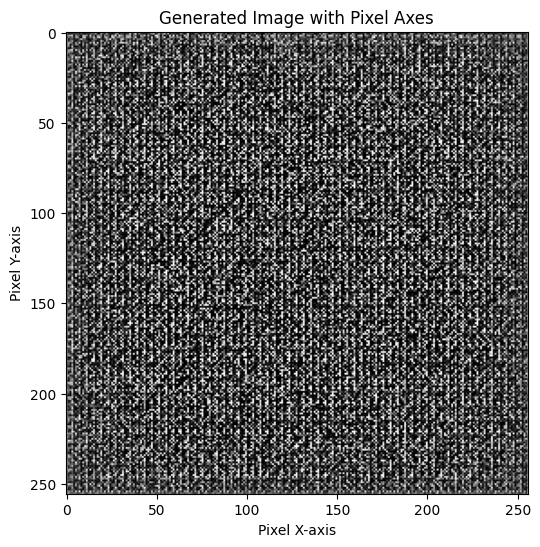

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Parameters for the generator
channels_noise = 100
channels_img = 1  # 1 channel for grayscale
features_g = 64
image_size = 256

# Create the generator
netG = Generator(channels_noise, channels_img, features_g)

# Generate random noise and pass it through the generator
noise = torch.randn(1, channels_noise, 1, 1)
fake_image = netG(noise)

# Convert the generated image to a format suitable for matplotlib
fake_image = fake_image.detach().cpu().squeeze(0).squeeze(0)
fake_image = (fake_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]

# Plot the generated image with pixel axes
plt.figure(figsize=(6, 6))
plt.imshow(fake_image.numpy(), cmap='gray')
plt.axis('on')
plt.xlabel('Pixel X-axis')
plt.ylabel('Pixel Y-axis')
plt.title('Generated Image with Pixel Axes')
plt.show()

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)




In [ ]:
# Initialize the generator and critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# Initialize the optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# Initialize TensorBoard writer
writer_real = SummaryWriter()
writer_fake = SummaryWriter()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

<IPython.core.display.Javascript object>

In [ ]:
def load_checkpoint(filename, model, optimizer, model_key, optimizer_key):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint[model_key])
    optimizer.load_state_dict(checkpoint[optimizer_key])
    return checkpoint['epoch']

In [ ]:
# Function to save the grid of generated images
def save_generated_images(epoch, gen, fixed_noise, save_dir):
    gen.eval()
    with torch.no_grad():
        fake_images = gen(fixed_noise).cpu()
    gen.train()

    fig, axes = plt.subplots(2, 4, figsize=(8, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch + 1}.png"))
    plt.close()

In [ ]:

start_epoch = 500
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_500_256x256.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, gen, opt_gen, 'gen_state_dict', 'gen_optimizer')
    load_checkpoint(checkpoint_path, critic, opt_critic, 'critic_state_dict', 'critic_optimizer')
    start_epoch += 1  # To continue from the next epoch

=> Loading checkpoint
=> Loading checkpoint


In [ ]:
gen.train()
critic.train()

# Training loop
for epoch in range(NUM_EPOCHS):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Generate fake images
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Log the losses to TensorBoard
        if batch_idx % 10 == 0:
            writer_real.add_scalar("Critic Loss", loss_critic.item(), global_step=epoch * len(loader) + batch_idx)
            writer_fake.add_scalar("Generator Loss", loss_gen.item(), global_step=epoch * len(loader) + batch_idx)

            with torch.no_grad():
                fake = gen(noise).detach().cpu()
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real Images", img_grid_real, global_step=epoch * len(loader) + batch_idx)
                writer_fake.add_image("Fake Images", img_grid_fake, global_step=epoch * len(loader) + batch_idx)

        # Update the progress bar
        loop.set_postfix(loss_critic=loss_critic.item(), loss_gen=loss_gen.item())

    print(f"Completed Epoch {epoch + 1}/{NUM_EPOCHS}.")  # Confirms the completion of the current epoch

    # Save the grid of generated images at the end of each epoch
    save_generated_images(epoch, gen, fixed_noise, save_dir="/content/drive/My Drive/GAN - Data Projekt/GAN_256x256_ShortCriticIter_GIF")

    # Save the model checkpoint after 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "critic_state_dict": critic.state_dict(),
            "gen_optimizer": opt_gen.state_dict(),
            "critic_optimizer": opt_critic.state_dict(),
        }
        save_checkpoint(checkpoint, filename=os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}_256x256_ShortCriticIter_GIF.pth"))

# Close the TensorBoard writers
writer_real.close()
writer_fake.close()

100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-214, loss_gen=-330]


Completed Epoch 1/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-165, loss_gen=-330]


Completed Epoch 2/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-184, loss_gen=-322]


Completed Epoch 3/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-200, loss_gen=-338]


Completed Epoch 4/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-142, loss_gen=-321]


Completed Epoch 5/1000.


100%|██████████| 37/37 [02:38<00:00,  4.30s/it, loss_critic=-197, loss_gen=-321]


Completed Epoch 6/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-211, loss_gen=-310]


Completed Epoch 7/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-183, loss_gen=-310]


Completed Epoch 8/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-242, loss_gen=-315]


Completed Epoch 9/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-179, loss_gen=-324]


Completed Epoch 10/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-194, loss_gen=-334]


Completed Epoch 11/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-221, loss_gen=-334]


Completed Epoch 12/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-222, loss_gen=-324]


Completed Epoch 13/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-174, loss_gen=-299]


Completed Epoch 14/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-180, loss_gen=-304]


Completed Epoch 15/1000.


100%|██████████| 37/37 [02:39<00:00,  4.30s/it, loss_critic=-188, loss_gen=-319]


Completed Epoch 16/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-219, loss_gen=-318]


Completed Epoch 17/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-257, loss_gen=-329]


Completed Epoch 18/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-139, loss_gen=-320]


Completed Epoch 19/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-202, loss_gen=-311]


Completed Epoch 20/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-204, loss_gen=-328]


Completed Epoch 21/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-244, loss_gen=-321]


Completed Epoch 22/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-203, loss_gen=-322]


Completed Epoch 23/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-117, loss_gen=-336]


Completed Epoch 24/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-172, loss_gen=-316]


Completed Epoch 25/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-155, loss_gen=-321]


Completed Epoch 26/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-177, loss_gen=-315]


Completed Epoch 27/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-118, loss_gen=-333]


Completed Epoch 28/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-198, loss_gen=-326]


Completed Epoch 29/1000.


100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss_critic=-186, loss_gen=-321]


Completed Epoch 30/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-193, loss_gen=-328]


Completed Epoch 31/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-154, loss_gen=-331]


Completed Epoch 32/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-166, loss_gen=-334]


Completed Epoch 33/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-193, loss_gen=-332]


Completed Epoch 34/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-229, loss_gen=-325]


Completed Epoch 35/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-182, loss_gen=-331]


Completed Epoch 36/1000.


100%|██████████| 37/37 [02:39<00:00,  4.30s/it, loss_critic=-174, loss_gen=-329]


Completed Epoch 37/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-205, loss_gen=-326]


Completed Epoch 38/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-209, loss_gen=-320]


Completed Epoch 39/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-175, loss_gen=-337]


Completed Epoch 40/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-209, loss_gen=-327]


Completed Epoch 41/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-192, loss_gen=-329]


Completed Epoch 42/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-172, loss_gen=-328]


Completed Epoch 43/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-224, loss_gen=-328]


Completed Epoch 44/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-187, loss_gen=-335]


Completed Epoch 45/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-190, loss_gen=-335]


Completed Epoch 46/1000.


100%|██████████| 37/37 [02:39<00:00,  4.31s/it, loss_critic=-226, loss_gen=-317]


Completed Epoch 47/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-202, loss_gen=-322]


Completed Epoch 48/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-152, loss_gen=-340]


Completed Epoch 49/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-155, loss_gen=-336]


Completed Epoch 50/1000.
=> Saving checkpoint


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-164, loss_gen=-333]


Completed Epoch 51/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-165, loss_gen=-331]


Completed Epoch 52/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-199, loss_gen=-331]


Completed Epoch 53/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-206, loss_gen=-321]


Completed Epoch 54/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-144, loss_gen=-333]


Completed Epoch 55/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-162, loss_gen=-324]


Completed Epoch 56/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-196, loss_gen=-320]


Completed Epoch 57/1000.


100%|██████████| 37/37 [02:39<00:00,  4.32s/it, loss_critic=-249, loss_gen=-316]


Completed Epoch 58/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-236, loss_gen=-330]


Completed Epoch 59/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-181, loss_gen=-319]


Completed Epoch 60/1000.


100%|██████████| 37/37 [02:37<00:00,  4.27s/it, loss_critic=-254, loss_gen=-324]


Completed Epoch 61/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-223, loss_gen=-337]


Completed Epoch 62/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-220, loss_gen=-330]


Completed Epoch 63/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-170, loss_gen=-341]


Completed Epoch 64/1000.


100%|██████████| 37/37 [02:38<00:00,  4.29s/it, loss_critic=-171, loss_gen=-337]


Completed Epoch 65/1000.


100%|██████████| 37/37 [02:38<00:00,  4.27s/it, loss_critic=-228, loss_gen=-333]


Completed Epoch 66/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-195, loss_gen=-331]


Completed Epoch 67/1000.


100%|██████████| 37/37 [02:38<00:00,  4.28s/it, loss_critic=-231, loss_gen=-335]


Completed Epoch 68/1000.


  5%|▌         | 2/37 [00:09<02:37,  4.50s/it, loss_critic=-167, loss_gen=-344]